## Force prediction scores

In [17]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.plot_prediction import plot_total_force, plot_force_components
from scipy.optimize import least_squares
import logging
log = logging.getLogger(__name__)
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [19]:
%reload_kedro
ship='wPCC'
force_prediction_scores = catalog.load(f"{ship}.force_prediction_scores")
mask = force_prediction_scores['model'].str.contains('.',regex=False)
force_prediction_scores=force_prediction_scores.loc[mask].copy()
force_prediction_scores['vmm'] = force_prediction_scores['model'].apply(lambda x: x.split('.')[0])
force_prediction_scores['regression'] = force_prediction_scores['model'].apply(lambda x: x.split('.')[1])
#force_prediction_scores.sort_values(by=['regression','vmm',], inplace=True)
force_prediction_scores['test_id'] = force_prediction_scores['test_id'].apply(lambda x: x.replace('wpcc.updated.','').replace('.ek_smooth',''))

[07/26/23 14:54:36] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=603679;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=996836;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/26/23 14:54:46] INFO     Kedro project phd                                                      ]8;id=708288;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=396470;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=507952;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=915172;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=799123;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=17851;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.force_prediction_scores' (CSVDataSet)...   ]8;id=178698;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=267138;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [20]:
force_prediction_scores.head()

,r2(X_D),rmse(X_D),r2(Y_D),rmse(Y_D),r2(N_D),rmse(N_D),model,test_id,mean(r2),mean(rmse),vmm,regression
0,-0.499917,0.379462,0.281037,0.155040,-2.064869,0.370571,vmm_7m_vct.MDL_hull_inverse_dynamics,22611,-0.761250,0.301691,vmm_7m_vct,MDL_hull_inverse_dynamics
1,-0.991644,0.437261,0.285565,0.154551,-1.609739,0.341951,vmm_7m_vct.VCT_MDL_resistance,22611,-0.771940,0.311254,vmm_7m_vct,VCT_MDL_resistance
2,-362.089137,5.903934,0.285565,0.154551,-1.609739,0.341951,vmm_7m_vct.vct,22611,-121.137770,2.133478,vmm_7m_vct,vct
3,-0.483830,0.377422,0.280793,0.155066,-2.069850,0.370872,vmm_7m_vct_wind.MDL_hull_inverse_dynamics,22611,-0.757629,0.301120,vmm_7m_vct_wind,MDL_hull_inverse_dynamics
4,-2.441720,0.574808,0.290134,0.154056,-1.636807,0.343719,vmm_7m_vct_wind.VCT_MDL_resistance,22611,-1.262798,0.357528,vmm_7m_vct_wind,VCT_MDL_resistance


In [21]:
force_prediction_scores['model'].unique()

array(['vmm_7m_vct.MDL_hull_inverse_dynamics',
       'vmm_7m_vct.VCT_MDL_resistance', 'vmm_7m_vct.vct',
       'vmm_7m_vct_wind.MDL_hull_inverse_dynamics',
       'vmm_7m_vct_wind.VCT_MDL_resistance', 'vmm_7m_vct_wind.vct',
       'vmm_martins_simple.MDL_hull_inverse_dynamics',
       'vmm_martins_simple.VCT_MDL_resistance', 'vmm_martins_simple.vct',
       'vmm_martins_simple_thrust.MDL_inverse_dynamics',
       'vmm_simple.VCT_MDL_resistance', 'vmm_simple.vct',
       'vmm_simple_wind.VCT_MDL_resistance', 'vmm_simple_wind.vct'],
      dtype=object)

In [22]:
force_prediction_scores.head()

,r2(X_D),rmse(X_D),r2(Y_D),rmse(Y_D),r2(N_D),rmse(N_D),model,test_id,mean(r2),mean(rmse),vmm,regression
0,-0.499917,0.379462,0.281037,0.155040,-2.064869,0.370571,vmm_7m_vct.MDL_hull_inverse_dynamics,22611,-0.761250,0.301691,vmm_7m_vct,MDL_hull_inverse_dynamics
1,-0.991644,0.437261,0.285565,0.154551,-1.609739,0.341951,vmm_7m_vct.VCT_MDL_resistance,22611,-0.771940,0.311254,vmm_7m_vct,VCT_MDL_resistance
2,-362.089137,5.903934,0.285565,0.154551,-1.609739,0.341951,vmm_7m_vct.vct,22611,-121.137770,2.133478,vmm_7m_vct,vct
3,-0.483830,0.377422,0.280793,0.155066,-2.069850,0.370872,vmm_7m_vct_wind.MDL_hull_inverse_dynamics,22611,-0.757629,0.301120,vmm_7m_vct_wind,MDL_hull_inverse_dynamics
4,-2.441720,0.574808,0.290134,0.154056,-1.636807,0.343719,vmm_7m_vct_wind.VCT_MDL_resistance,22611,-1.262798,0.357528,vmm_7m_vct_wind,VCT_MDL_resistance


In [23]:
force_prediction_scores['test_id'].unique()

array(['22611', '22612', '22613', '22614', '22615', '22616', '22635',
       '22639', '22764', '22769', '22770', '22771', '22772', '22773',
       '22774', 'joined'], dtype=object)

In [24]:
force_prediction_scores.groupby(by=['model']).mean(numeric_only=True)

,r2(X_D),rmse(X_D),r2(Y_D),rmse(Y_D),r2(N_D),rmse(N_D),mean(r2),mean(rmse)
model,,,,,,,,
vmm_7m_vct.MDL_hull_inverse_dynamics,0.132936,0.614086,-0.416442,4.251225,-0.949763,2.227773,-0.411090,2.364361
vmm_7m_vct.VCT_MDL_resistance,-0.875954,1.333385,-3.340242,6.232566,-14.651711,11.019058,-6.289302,6.195003
vmm_7m_vct.vct,-151.220312,5.972678,-3.340242,6.232566,-14.651711,11.019058,-56.404088,7.741434
vmm_7m_vct_wind.MDL_hull_inverse_dynamics,0.137547,0.612811,-0.415040,4.250660,-0.953970,2.227826,-0.410488,2.363765
vmm_7m_vct_wind.VCT_MDL_resistance,-1.220540,1.337099,-3.317309,6.248929,-14.609325,10.988799,-6.382391,6.191609
vmm_7m_vct_wind.vct,-141.357980,5.804063,-3.317309,6.248929,-14.609325,10.988799,-53.094871,7.680597
vmm_martins_simple.MDL_hull_inverse_dynamics,-0.496593,0.771676,-1.070678,4.948747,-0.029441,1.190694,-0.532237,2.303706
vmm_martins_simple.VCT_MDL_resistance,-0.000779,0.757294,-4.726702,4.817658,-8.528454,9.105893,-4.418645,4.893615
vmm_martins_simple.vct,-138.360883,4.827773,-4.726702,4.817658,-8.528454,9.105893,-50.538680,6.250442


In [25]:
force_prediction_scores.groupby(by=['model']).max(numeric_only=True)

,r2(X_D),rmse(X_D),r2(Y_D),rmse(Y_D),r2(N_D),rmse(N_D),mean(r2),mean(rmse)
model,,,,,,,,
vmm_7m_vct.MDL_hull_inverse_dynamics,0.977857,1.528003,0.838181,12.848610,0.957578,8.486445,0.776585,7.256056
vmm_7m_vct.VCT_MDL_resistance,0.215852,3.497265,0.872591,41.055849,0.837620,75.869161,0.098849,40.140758
vmm_7m_vct.vct,-3.238867,7.263798,0.872591,41.055849,0.837620,75.869161,-2.591097,40.972519
vmm_7m_vct_wind.MDL_hull_inverse_dynamics,0.978002,1.527799,0.838356,12.848650,0.957603,8.485800,0.776620,7.255382
vmm_7m_vct_wind.VCT_MDL_resistance,0.253743,3.440418,0.867727,41.351732,0.828283,75.651517,0.265255,40.147889
vmm_7m_vct_wind.vct,-3.137929,7.113471,0.867727,41.351732,0.828283,75.651517,-2.451105,40.974672
vmm_martins_simple.MDL_hull_inverse_dynamics,0.828736,1.842549,0.695765,12.792815,0.984758,3.536103,0.774709,5.587149
vmm_martins_simple.VCT_MDL_resistance,0.820520,1.824386,0.853430,17.969799,0.923069,41.236568,0.524331,20.182990
vmm_martins_simple.vct,0.566773,5.759358,0.853430,17.969799,0.923069,41.236568,-0.727377,20.374047


In [26]:
force_prediction_scores.groupby('test_id').get_group('joined').sort_values(by='mean(rmse)', ascending=True)

,r2(X_D),rmse(X_D),r2(Y_D),rmse(Y_D),r2(N_D),rmse(N_D),model,test_id,mean(r2),mean(rmse),vmm,regression
219,0.827365,0.954269,0.985857,1.341348,0.982851,1.017887,vmm_martins_simple_thrust.MDL_inverse_dynamics,joined,0.932024,1.104501,vmm_martins_simple_thrust,MDL_inverse_dynamics
222,0.060142,2.226574,0.938755,2.791329,0.842227,3.087405,vmm_simple_wind.VCT_MDL_resistance,joined,0.613708,2.701769,vmm_simple_wind,VCT_MDL_resistance
220,0.009782,2.285449,0.932465,2.931155,0.851581,2.994478,vmm_simple.VCT_MDL_resistance,joined,0.597943,2.737027,vmm_simple,VCT_MDL_resistance
216,0.828736,0.950471,0.543800,7.618186,0.951591,1.710173,vmm_martins_simple.MDL_hull_inverse_dynamics,joined,0.774709,3.426277,vmm_martins_simple,MDL_hull_inverse_dynamics
213,0.909460,0.691075,0.611095,7.033891,0.721624,4.101028,vmm_7m_vct_wind.MDL_hull_inverse_dynamics,joined,0.747393,3.941998,vmm_7m_vct_wind,MDL_hull_inverse_dynamics
210,0.909194,0.692091,0.611088,7.033957,0.721655,4.100800,vmm_7m_vct.MDL_hull_inverse_dynamics,joined,0.747312,3.942283,vmm_7m_vct,MDL_hull_inverse_dynamics
223,-6.146412,6.139741,0.938755,2.791329,0.842227,3.087405,vmm_simple_wind.vct,joined,-1.455144,4.006158,vmm_simple_wind,vct
221,-6.509904,6.293949,0.932465,2.931155,0.851581,2.994478,vmm_simple.vct,joined,-1.575286,4.073194,vmm_simple,vct
217,0.820520,0.973003,0.407547,8.681627,-4.932156,18.931416,vmm_martins_simple.VCT_MDL_resistance,joined,-1.234696,9.528682,vmm_martins_simple,VCT_MDL_resistance
218,-3.082010,4.640268,0.407547,8.681627,-4.932156,18.931416,vmm_martins_simple.vct,joined,-2.535540,10.751104,vmm_martins_simple,vct


In [27]:
mask = (force_prediction_scores['test_id'] != 'wpcc.updated.joined.ek_smooth')
df = force_prediction_scores.loc[mask].copy()
#df.sort_values(by=['regression','vmm',], inplace=True)

In [28]:
df.pivot(index='test_id', columns='model', values=['mean(rmse)','regression'])

mean(rmse)                                                                                                                                                                                                                                                                                                                                                                                                                                      regression                                                                                                                                                                                                                                                                                                                                                                                                           
model   vmm_7m_vct.MDL_hull_inverse_dynamics vmm_7m_vct.VCT_MDL_resistance vmm_7m_vct.vct vmm_7m_vct_wind.MDL_hull_inverse_dynamics vmm_7m_vct_wind.VCT_MDL_resistance vmm_7m_vct_wind.vct vmm_martins_simple.MDL_hull_inverse_dynamics vmm_martins_simple.VCT_MDL_resistance vmm_martins_simple.vct vmm_martins_simple_thrust.MDL_inverse_dynamics vmm_simple.VCT_MDL_resistance vmm_simple.vct vmm_simple_wind.VCT_MDL_resistance vmm_simple_wind.vct vmm_7m_vct.MDL_hull_inverse_dynamics vmm_7m_vct.VCT_MDL_resistance vmm_7m_vct.vct vmm_7m_vct_wind.MDL_hull_inverse_dynamics vmm_7m_vct_wind.VCT_MDL_resistance vmm_7m_vct_wind.vct vmm_martins_simple.MDL_hull_inverse_dynamics vmm_martins_simple.VCT_MDL_resistance vmm_martins_simple.vct vmm_martins_simple_thrust.MDL_inverse_dynamics vmm_simple.VCT_MDL_resistance vmm_simple.vct vmm_simple_wind.VCT_MDL_resistance vmm_simple_wind.vct
test_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
22611                               0.301691                      0.311254       2.133478                                   0.30112                           0.357528            2.067042                                     0.257809                              0.939841               2.734131                                       0.225092                      0.325454       2.171658                           0.368471            2.105725            MDL_hull_inverse_dynamics            VCT_MDL_resistance            vct                 MDL_hull_inverse_dynamics                 VCT_MDL_resistance                 vct                    MDL_hull_inverse_dynamics                    VCT_MDL_resistance                    vct                           MDL_inverse_dynamics            VCT_MDL_resistance            vct                 VCT_MDL_resistance                 vct
22612                               0.490179                      0.609932       2.372626                                  0.489102                           0.650384            2.305912                                     0.481407                              1.179452               2.902082                                       0.478706                      0.517359       2.302725                           0.550451            2.232166            MDL_hull_inverse_dynamics            VCT_MDL_resistance            vct                 MDL_hull

In [29]:
def compare_scores(key = 'mean(rmse)'):
    nrows=len(df['vmm'].unique())
    fig,axes=plt.subplots(nrows=nrows)
    fig.set_size_inches(17,8)
    
    
    for i,(vmm, group) in enumerate(df.groupby(by='vmm')):
        
        ax=axes[i]
        ax.set_title(vmm)
        group.pivot(index='test_id', columns='regression', values=key).plot.bar(ax=ax)
        if i<nrows-1:
            ax.set_xticklabels([])
            ax.set_xlabel('')
        else:
            ax.legend(loc='upper left')
        
        ax.set_ylim(df[key].min(),df[key].max())
        ax.set_ylabel(key)
        
    plt.tight_layout()

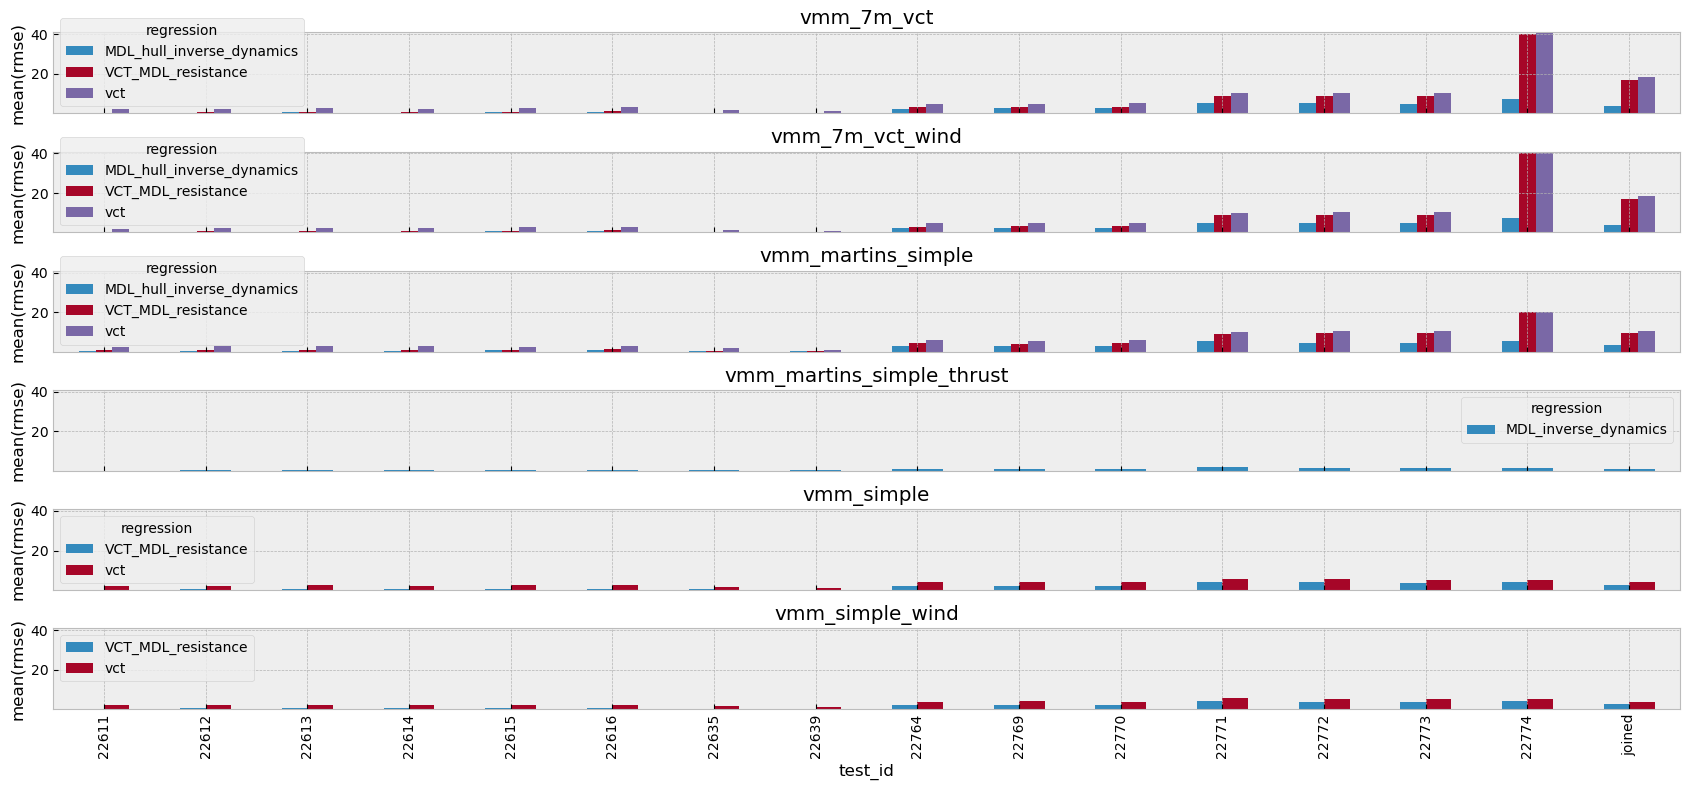

In [30]:
compare_scores()

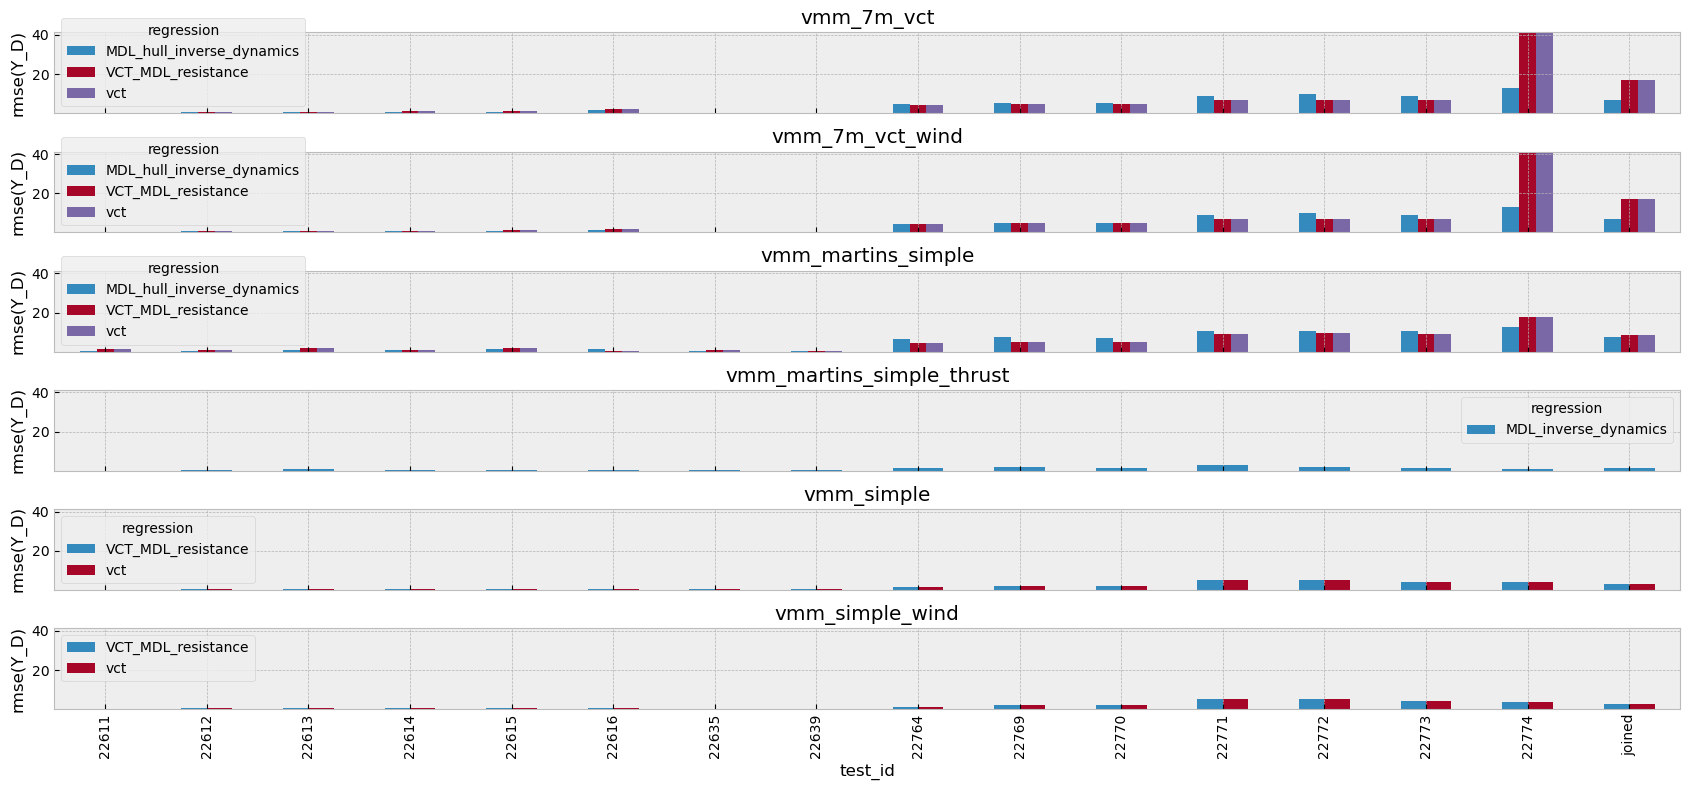

In [31]:
compare_scores('rmse(Y_D)')

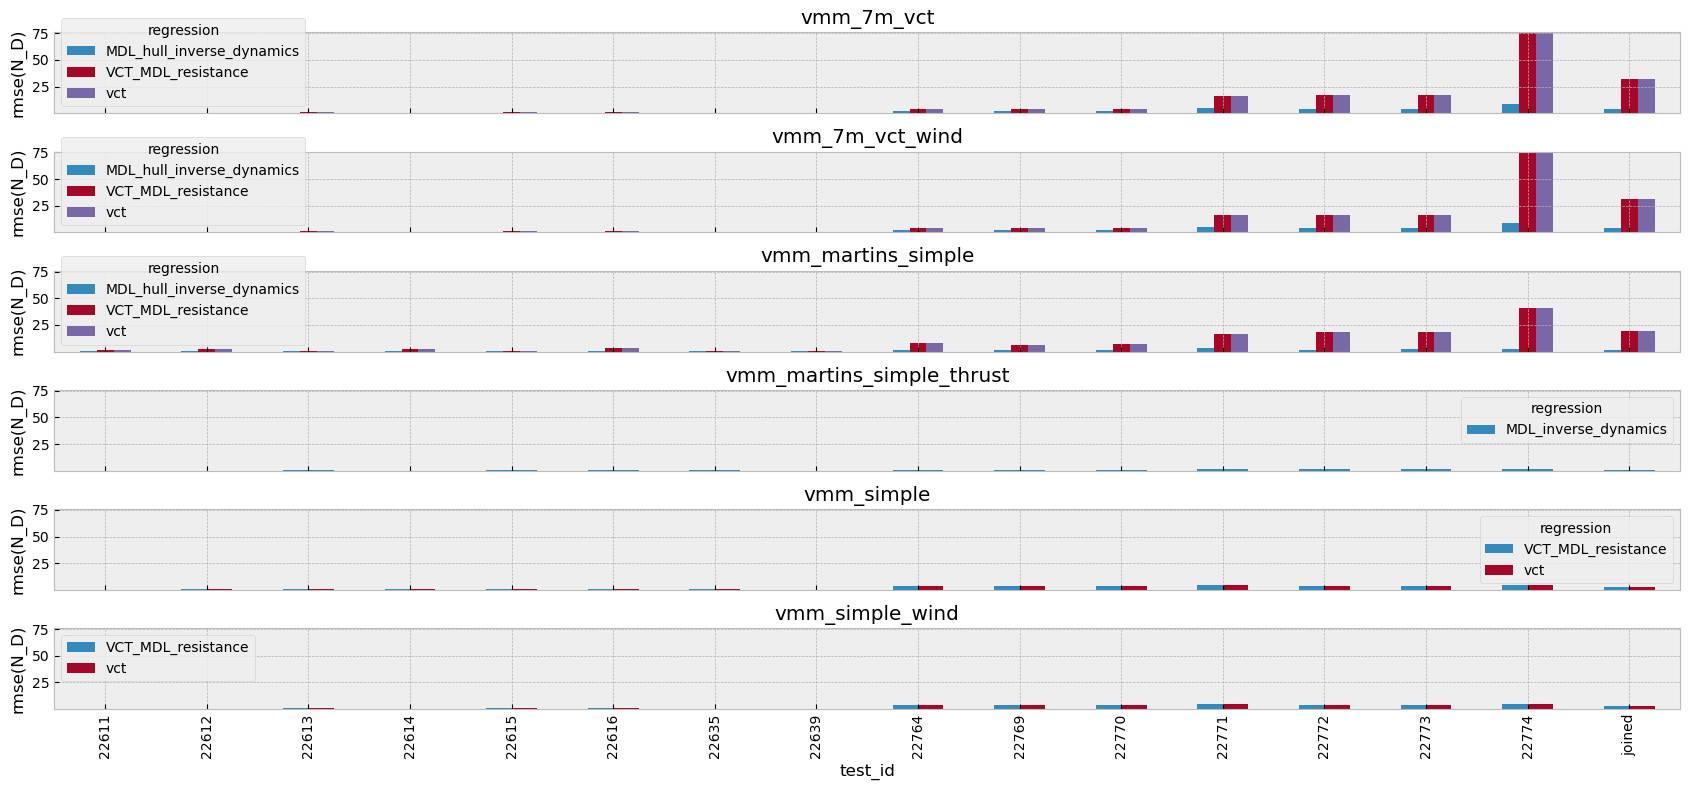

In [32]:
compare_scores('rmse(N_D)')